In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [6]:
# Code -- https://github.com/alexandru-dinu/cae
# DataBase -- https://www.kaggle.com/hsankesara/flickr-image-dataset




img_dir = 'data/archive_small/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

8


In [7]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
#         print("hey  "*4 + str(index))
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
#         img = (img - 255.0) / 255.0
        return img

In [8]:
batch_size=5
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


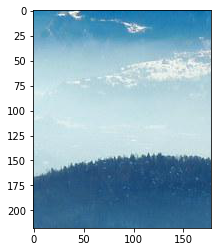

In [10]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[3]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [11]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

num_channels_in_encoder = 28

In [13]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [14]:
device

'cpu'

In [15]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)*100) )

torch.Size([100, 28, 54, 44])
The Compression Ratio is :  57.148747551798785


In [16]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # DECODER
#         self.latent_fc1 = nn.Sequential(
#             nn.Linear(latent_size,1000),
#             nn.Sigmoid(),
#         )
#         self.latent_fc2 = nn.Sequential(
#             nn.Linear(1000,54*44),
#             nn.Sigmoid(),
#         )
        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [17]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [12]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [13]:
netD = Discriminator().to('cpu')
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44))
output = netD(inp_x)
output.shape

torch.Size([100, 1])

In [5]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

NameError: name 'netD' is not defined

In [ ]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 7

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        
        netD.zero_grad()
        
        images = images.to(device)
        fake_images = netG(netE(images))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Create a fake pair batch --

        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)
        
#         label = torch.full((images.size(0),), real_label, device=device)
        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
#         label.fill_(fake_label)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
#         label.fill_(real_label)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + 2*l1criterion(images,fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        netE.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errE = criterion(output, label) + 2*l1criterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()
        
        #################################_______STATS________###########################################
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_E: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),errE.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             netG.eval()
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#                 fake[:] = fake[:]*0.5 + 0.5
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        torch.cuda.empty_cache()
        iters += 1
        
        
        
        if i%500 ==0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            f, axarr = plt.subplots(num_images_to_show,2)
            for i in range(num_images_to_show):
                validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5 ) + 0.5
                axarr[0].imshow(validimg)
                axarr[1].imshow(rec_img)
                f.set_figheight(20)
                f.set_figwidth(20)
            plt.show()

In [ ]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3
# print("Size reduction is : "+ str(float(encode_size/tot_img_size)*100.0)+" percent")

In [ ]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

In [ ]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [ ]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")